In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import join, basename
from glob import glob
import torch
from CVPR24_infer import infer_npz_2D, infer_npz_3D
from src.efficient_sam.build_efficient_sam import build_efficient_sam_vitt, build_efficient_sam_vits
from src.segment_anything import sam_model_registry
from src.litemedsam.build_sam import build_sam_vit_t
from time import time
import gc
from datetime import datetime
# import sys
# sys.path.append("/scratch/user/uqxye5/segmentation/cvpr-sam-on-laptop-2024")
from evaluation.SurfaceDice import compute_surface_distances, compute_surface_dice_at_tolerance, compute_dice_coefficient
# from evaluation.compute_metrics import compute_multi_class_dsc, compute_multi_class_nsd
from src.visual_util import show_box, show_mask
import pandas as pd
import json

In [2]:
# load test demo data
demo_imgs = sorted(glob(os.path.join('/scratch/project/bollmann_lab/MedSAM_Laptop/datasets/test_demo/imgs', '*')))
demo_gts = sorted(glob(os.path.join('/scratch/project/bollmann_lab/MedSAM_Laptop/datasets/test_demo/gts', '*')))
print('number of data',len(demo_imgs))
test_imgs = np.load(demo_imgs[-1],allow_pickle=True)
print(demo_imgs[-1], list(test_imgs.keys()))
print('mean', np.mean(test_imgs['imgs']), 'min', np.min(test_imgs['imgs']), 'max', np.max(test_imgs['imgs']))

number of data 10
/scratch/project/bollmann_lab/MedSAM_Laptop/datasets/test_demo/imgs/3DBox_MR_demo.npz ['imgs', 'spacing', 'boxes']
mean 41.10066136448949 min 0 max 255


In [14]:
# arguments to run the inference
img_npz_file = demo_imgs[-3]
gt_npz_file = demo_gts[-3]
model_name = 'litemedsam' # options: 'litemedsam', 'efficientsam', 'medsam'
checkpoint_path = '/scratch/project/bollmann_lab/MedSAM_Laptop/checkpoints/LiteMedSAM/lite_medsam.pth'
pred_save_dir = None
save_overlay = False
png_save_dir = None

In [15]:
# run inference
device = 'cpu'
torch.set_float32_matmul_precision('high')
torch.manual_seed(2024)
torch.cuda.manual_seed(2024)
np.random.seed(2024)

if model_name == 'efficientsam':
    model = build_efficient_sam_vitt(checkpoint_path)
    if 'vits' in checkpoint_path:
        model = build_efficient_sam_vits(checkpoint_path)
elif model_name == 'medsam':
    model = sam_model_registry["vit_b"](checkpoint=checkpoint_path)
elif model_name == 'litemedsam':
    model = build_sam_vit_t(checkpoint_path)  
model.to(device)
model.eval()

start_time = time()
gc.collect()
if basename(img_npz_file).startswith('3D'):
    img_3c, segs, image_size = infer_npz_3D(model, model_name, img_npz_file, pred_save_dir, save_overlay, png_save_dir)
else:
    img_3c, segs, image_size = infer_npz_2D(model, model_name, img_npz_file, pred_save_dir, save_overlay, png_save_dir)
end_time = time()
current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(current_time, 'file name:', basename(img_npz_file), 'image size', image_size, 'time cost:', np.round(end_time - start_time, 4))

2024-04-17 11:53:39 file name: 2DBox_US_demo.npz image size (420, 580, 3) time cost: 0.6827


In [16]:
# metrics
def compute_multi_class_dsc(gt, seg):
    dsc = []
    for i in range(1, gt.max()+1):
        gt_i = gt == i
        seg_i = seg == i
        dsc.append(compute_dice_coefficient(gt_i, seg_i))
    return np.mean(dsc)

def compute_multi_class_nsd(gt, seg, spacing, tolerance=2.0):
    nsd = []
    for i in range(1, gt.max()+1):
        gt_i = gt == i
        seg_i = seg == i
        surface_distance = compute_surface_distances(
            gt_i, seg_i, spacing_mm=spacing
        )
        nsd.append(compute_surface_dice_at_tolerance(surface_distance, tolerance))
    return np.mean(nsd)


In [17]:
# compute metrics
metric_dict = {'dsc': -1.}

metric_dict['nsd'] = -1.
npz_data = np.load(img_npz_file, 'r', allow_pickle=True)
boxes = npz_data['boxes']
npz_gt = np.load(gt_npz_file, allow_pickle=True, mmap_mode='r')
gts = npz_gt['gts']
npz_name = basename(gt_npz_file)

if npz_name.startswith('3D'):
    spacing = npz_gt['spacing']

dsc = compute_multi_class_dsc(gts, segs)
# comupute nsd

if dsc > 0.2:
# only compute nsd when dice > 0.2 because NSD is also low when dice is too low
    if npz_name.startswith('3D'):
        nsd = compute_multi_class_nsd(gts, segs, spacing)
    else:
        spacing = [1.0, 1.0, 1.0]
        nsd = compute_multi_class_nsd(np.expand_dims(gts, -1), np.expand_dims(segs, -1), spacing)
else:
    nsd = 0.0

print(npz_name, dsc, nsd)

2DBox_US_demo.npz 0.8745690798196765 0.9220455666584362


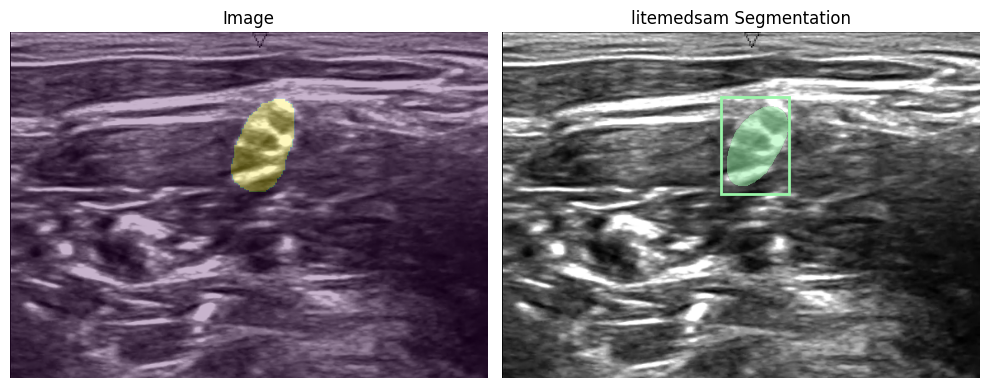

In [26]:
# visualize prediction
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

if npz_name.startswith('3D'):
    idx = int(segs.shape[0] / 2)
    ax[0].imshow(img_3c[idx], cmap='gray')
    if gts is not None:
        ax[0].imshow(gts[idx], alpha=0.3)
    ax[1].imshow(img_3c[idx],cmap='gray')
    ax[0].set_title("Image")
    ax[1].set_title(f"{model_name} Segmentation")
    ax[0].axis('off')
    ax[1].axis('off')
    for i, box3D in enumerate(boxes, start=1):
            if np.sum(segs[idx]==i) > 0:
                color = np.random.rand(3)
                x_min, y_min, z_min, x_max, y_max, z_max = box3D
                box_viz = np.array([x_min, y_min, x_max, y_max])
                show_box(box_viz, ax[1], edgecolor=color)
                show_mask(segs[idx]==i, ax[1], mask_color=color)

elif npz_name.startswith('2D'):
    ax[0].imshow(img_3c)
    if gts is not None:
        ax[0].imshow(gts, alpha=0.3)
    ax[1].imshow(img_3c)
    ax[0].set_title("Image")
    ax[1].set_title(f"{model_name} Segmentation")
    ax[0].axis('off')
    ax[1].axis('off')
    for i, box in enumerate(boxes):
        color = np.random.rand(3)
        box_viz = box
        show_box(box_viz, ax[1], edgecolor=color)
        show_mask((segs == i+1).astype(np.uint8), ax[1], mask_color=color)

plt.tight_layout()

In [30]:
# Calculate dominance
def is_dominated(x, y, X, Y):
    return np.any((X > x) & (Y < y))

def find_pareto_front(x, y):
    pareto_front = []
    for i in range(len(x)):
        if not is_dominated(x[i], y[i], x, y):
            pareto_front.append((x[i], y[i]))
    return pareto_front

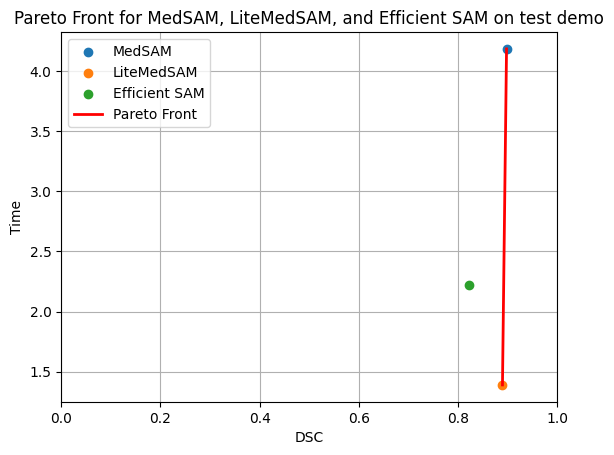

In [23]:
# pareto front for test demo
medsam_dsc = 0.8977
medsam_time = 4.1832

litemedsam_dsc = 0.8895
litemedsam_time =1.3896

efficientsam_dsc = 0.8222
efficientsam_time = 2.2165

# Plot the points for each model
plt.scatter(medsam_dsc, medsam_time, label='MedSAM')
plt.scatter(litemedsam_dsc, litemedsam_time, label='LiteMedSAM')
plt.scatter(efficientsam_dsc, efficientsam_time, label='Efficient SAM')

# Plot the Pareto front
dsc = np.array([medsam_dsc, litemedsam_dsc, efficientsam_dsc])
time = np.array([medsam_time, litemedsam_time, efficientsam_time])
pareto_front = find_pareto_front(dsc, time)
pareto_front_x = [point[0] for point in pareto_front]
pareto_front_y = [point[1] for point in pareto_front]
# plt.plot(*zip(*pareto_front), color='red', label='Pareto Front')
plt.plot(pareto_front_x, pareto_front_y, color='red', label='Pareto Front', linewidth=2)

# Add labels and legend
plt.xlim(0, 1)
plt.xlabel('DSC')
plt.ylabel('Time')
plt.title('Pareto Front for MedSAM, LiteMedSAM, and Efficient SAM on test demo')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [2]:
# read validation time json file
litemedsam_time = pd.read_csv(open('/scratch/project/bollmann_lab/MedSAM_Laptop/datasets/validation/segs_litemedsam/efficiency.csv'))
medsam_time = pd.read_csv(open('/scratch/project/bollmann_lab/MedSAM_Laptop/datasets/validation/segs_medsam_cpu/efficiency.csv'))
efficientsam_time = pd.read_csv(open('/scratch/project/bollmann_lab/MedSAM_Laptop/datasets/validation/segs_efficientsam/efficiency.csv'))

In [3]:
img_sizes_str = efficientsam_time['image size']
img_sizes = []
for size in img_sizes_str:
    size = size.split('[')[1].split(']')[0].split(',')
    size = [int(s) for s in size]
    img_sizes.append(size)
img_sizes = np.array(img_sizes)

In [4]:
for i,case in enumerate(litemedsam_time['case']):
    if case.startswith('3D'):
        # print(litemedsam_time['time'][i], img_sizes[i][0])
        # print(litemedsam_time['time'][i] / img_sizes[i][0])
        litemedsam_time.loc[i, 'time'] = litemedsam_time['time'][i] / img_sizes[i][0]
        medsam_time.loc[i, 'time'] = medsam_time['time'][i] / img_sizes[i][0]
        efficientsam_time.loc[i, 'time'] = efficientsam_time['time'][i] / img_sizes[i][0]
        # break

In [7]:
litemedsam_time_modality = {}
medsam_time_modality = {}
efficientsam_time_modality = {}
for i,case in enumerate(litemedsam_time['case']):
    modality = case.split('_')[1]
    if modality not in litemedsam_time_modality.keys():
        litemedsam_time_modality[modality] = []
        medsam_time_modality[modality] = []
        efficientsam_time_modality[modality] = []
    litemedsam_time_modality[modality].append(litemedsam_time['time'][i])
    medsam_time_modality[modality].append(medsam_time['time'][i])
    efficientsam_time_modality[modality].append(efficientsam_time['time'][i])

In [13]:
l_lite = 0
l_med = 0
l_effi = 0
for key in litemedsam_time_modality.keys():
    l_lite += len(litemedsam_time_modality[key])
    l_med += len(medsam_time_modality[key])
    l_effi += len(efficientsam_time_modality[key])
print(l_lite, l_med, l_effi)

3076 3076 3076


In [14]:
time_avg_lite = {}
time_avg_med = {}
time_avg_effi = {}
for key in litemedsam_time_modality.keys():
    time_avg_lite[key] = np.mean(litemedsam_time_modality[key])
    time_avg_med[key] = np.mean(medsam_time_modality[key])
    time_avg_effi[key] = np.mean(efficientsam_time_modality[key])

In [23]:
time_avg_lite['AVG'] = np.mean(list(time_avg_lite.values()))
time_avg_med['AVG'] = np.mean(list(time_avg_med.values()))
time_avg_effi['AVG'] = np.mean(list(time_avg_effi.values()))

In [27]:
json.dump(time_avg_lite, open('/scratch/project/bollmann_lab/MedSAM_Laptop/results/validation/litemedsam_avg_runtime.json', 'w'))
json.dump(time_avg_med, open('/scratch/project/bollmann_lab/MedSAM_Laptop/results/validation/medsam_avg_runtime.json', 'w'))
json.dump(time_avg_effi, open('/scratch/project/bollmann_lab/MedSAM_Laptop/results/validation/efficientsam_avg_runtime.json', 'w'))

In [28]:
time_avg_lite['AVG'], time_avg_med['AVG'], time_avg_effi['AVG'] 

(7.589209706828007, 13.09427274941233, 8.90967416462984)

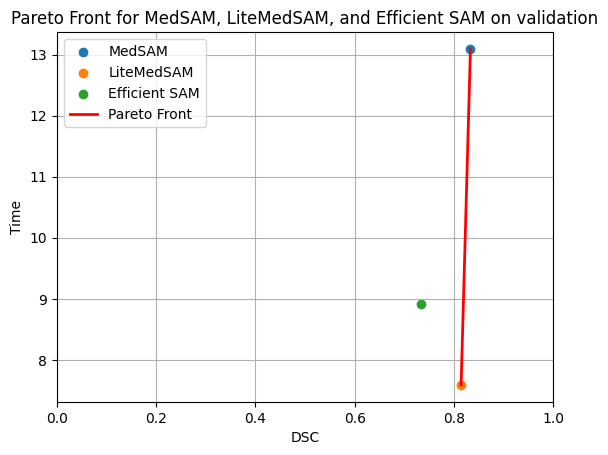

In [31]:
# pareto front for validation
medsam_dsc = 0.8335
medsam_time = 13.09427274941233

litemedsam_dsc = 0.8147
litemedsam_time =7.589209706828007

efficientsam_dsc = 0.7340
efficientsam_time = 8.90967416462984

# Plot the points for each model
plt.scatter(medsam_dsc, medsam_time, label='MedSAM')
plt.scatter(litemedsam_dsc, litemedsam_time, label='LiteMedSAM')
plt.scatter(efficientsam_dsc, efficientsam_time, label='Efficient SAM')

# Plot the Pareto front
dsc = np.array([medsam_dsc, litemedsam_dsc, efficientsam_dsc])
time = np.array([medsam_time, litemedsam_time, efficientsam_time])
pareto_front = find_pareto_front(dsc, time)
pareto_front_x = [point[0] for point in pareto_front]
pareto_front_y = [point[1] for point in pareto_front]
# plt.plot(*zip(*pareto_front), color='red', label='Pareto Front')
plt.plot(pareto_front_x, pareto_front_y, color='red', label='Pareto Front', linewidth=2)

# Add labels and legend
plt.xlim(0, 1)
plt.xlabel('DSC')
plt.ylabel('Time')
plt.title('Pareto Front for MedSAM, LiteMedSAM, and Efficient SAM on validation')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()